<a href="https://colab.research.google.com/github/oakeshott/ai-based-networking-2021/blob/master/jupyter/pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNISTを利用したPytorchのチュートリアル

In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

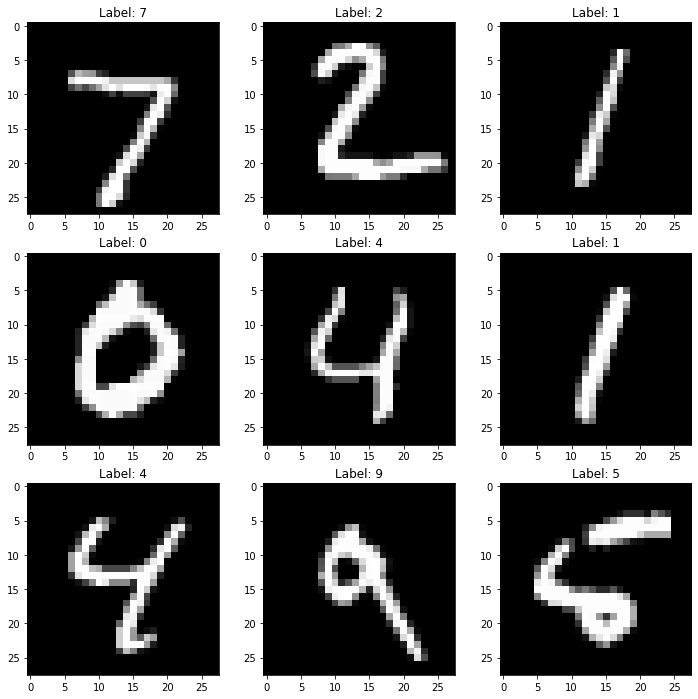

In [ ]:
# 利用データの確認
data = datasets.MNIST('/tmp/data', train=False, download=True, transform=transforms.ToTensor())
data_loader = DataLoader(data,
                         batch_size=10,
                         shuffle=False)
data_iter = iter(data_loader)
images, labels = data_iter.next()
fig = plt.figure(figsize=(12, 12))
for i in range(0, 9):
    npimg = images[i].numpy()
    npimg = npimg.reshape((28, 28))
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(npimg, cmap='gray')
    ax.set_title(f"Label: {labels[i]}")


In [ ]:
# パラメタ
batch_size = 4
lr = 1e-2
log_interval = 2500
max_epoch = 3
if torch.cuda.is_available():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# データのロード
train_data   = datasets.MNIST('/tmp/data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data   = datasets.MNIST('/tmp/data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# 学習モデルの定義
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
model = Net() # 学習モデル
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr) # 最適化アルゴリズム
loss_func = nn.CrossEntropyLoss() # 損失関数
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
# 訓練
for epoch in range(1, max_epoch+1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()

        output = model(data)

        loss = loss_func(output, target)

        loss.backward()
        optimizer.step()

        if batch_idx % log_interval+1 == 0:
            print(f'Train Epoch: {epoch} [{ batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

In [ ]:
# テスト
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)

        output = model(data)

        loss = loss_func(output, target)
        test_loss += loss.item()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')

Test set: Average loss: 0.0001, Accuracy: 9613/10000 (96%)
